In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [4]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1513/1513 [00:08<00:00, 186.81GRB/s]


In [5]:
features.shape

(1513, 48000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


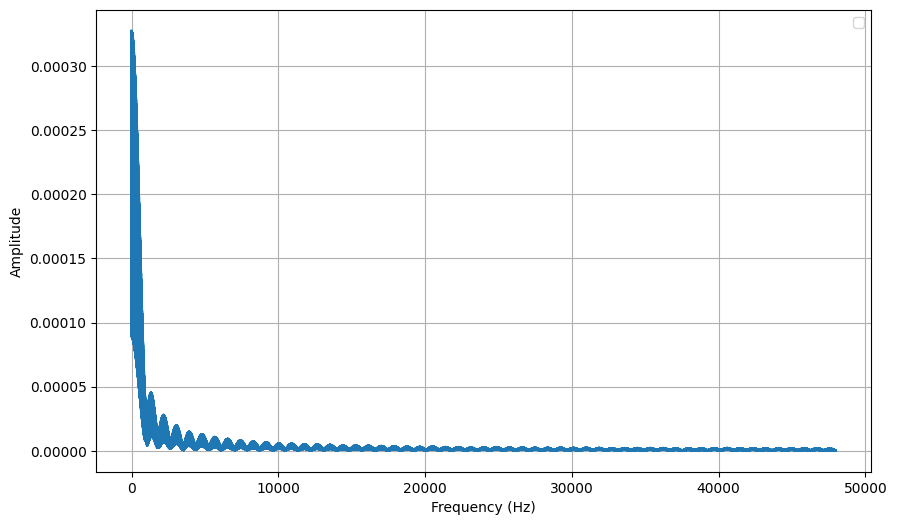

In [6]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0])  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.legend()
plt.grid(True)

In [7]:
features = features[:,:2000]
features.shape

(1513, 2000)

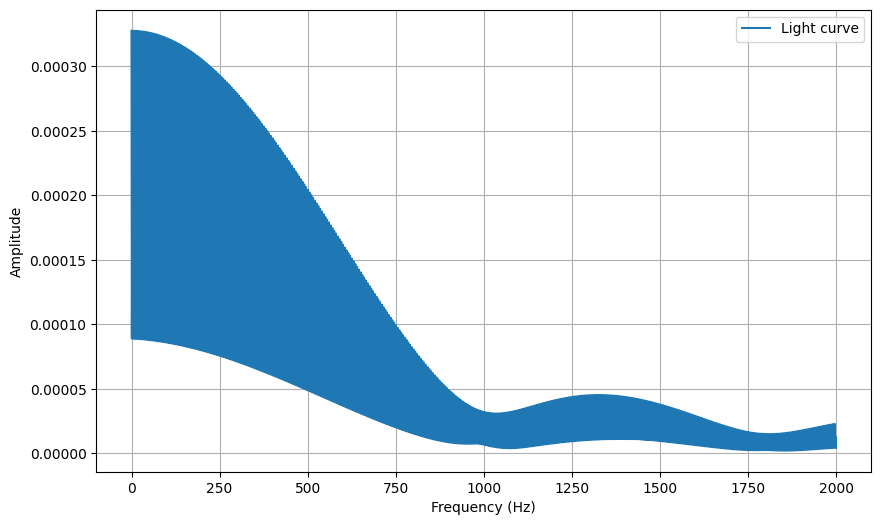

In [8]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0], label='Light curve')  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

In [9]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1513, 2000)
[5.68434189e-17 5.68434189e-17 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1. 1. 1. ... 1. 1. 1.]


In [10]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [11]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

In [12]:

# Split the cleaned data into training and testing sets
X_train, X_test, class_train, class_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=205)


training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 64

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [13]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 2
HIDDEN_SIZE_1     = 100

In [14]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        x      = self.fc2(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [15]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [16]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [17]:
features.shape

(1513, 2000)

In [18]:
from tqdm import tqdm

EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in tqdm(range(EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
train loss: 0.999741  [    0/ 1210]


  0%|▏                                          | 1/200 [00:02<09:29,  2.86s/it]

 Avg test loss: 0.930277 

Epoch 2
-------------------------------
train loss: 0.933166  [    0/ 1210]


  1%|▍                                          | 2/200 [00:03<04:30,  1.37s/it]

 Avg test loss: 0.649431 

Epoch 3
-------------------------------
train loss: 0.670112  [    0/ 1210]


  2%|▊                                          | 4/200 [00:03<01:54,  1.72it/s]

 Avg test loss: 0.439723 

Epoch 4
-------------------------------
train loss: 0.452352  [    0/ 1210]
 Avg test loss: 0.345868 

Epoch 5
-------------------------------
train loss: 0.359190  [    0/ 1210]


  3%|█▎                                         | 6/200 [00:04<01:36,  2.02it/s]

 Avg test loss: 0.293695 

Epoch 6
-------------------------------
train loss: 0.307938  [    0/ 1210]
 Avg test loss: 0.270606 

Epoch 7
-------------------------------
train loss: 0.286971  [    0/ 1210]


  4%|█▌                                         | 7/200 [00:05<02:03,  1.57it/s]

 Avg test loss: 0.259018 

Epoch 8
-------------------------------
train loss: 0.246639  [    0/ 1210]


  4%|█▋                                         | 8/200 [00:07<03:27,  1.08s/it]

 Avg test loss: 0.256451 

Epoch 9
-------------------------------
train loss: 0.271369  [    0/ 1210]


  4%|█▉                                         | 9/200 [00:09<04:45,  1.49s/it]

 Avg test loss: 0.255763 

Epoch 10
-------------------------------
train loss: 0.257410  [    0/ 1210]


  5%|██                                        | 10/200 [00:10<04:04,  1.29s/it]

 Avg test loss: 0.254603 

Epoch 11
-------------------------------
train loss: 0.267379  [    0/ 1210]


  6%|██▎                                       | 11/200 [00:11<03:09,  1.00s/it]

 Avg test loss: 0.253991 

Epoch 12
-------------------------------
train loss: 0.246903  [    0/ 1210]


  6%|██▌                                       | 12/200 [00:11<02:40,  1.17it/s]

 Avg test loss: 0.252872 

Epoch 13
-------------------------------
train loss: 0.255354  [    0/ 1210]


  7%|██▉                                       | 14/200 [00:12<01:52,  1.65it/s]

 Avg test loss: 0.253416 

Epoch 14
-------------------------------
train loss: 0.243489  [    0/ 1210]
 Avg test loss: 0.253768 

Epoch 15
-------------------------------
train loss: 0.248874  [    0/ 1210]


  8%|███▎                                      | 16/200 [00:12<01:09,  2.66it/s]

 Avg test loss: 0.251912 

Epoch 16
-------------------------------
train loss: 0.258283  [    0/ 1210]
 Avg test loss: 0.251040 

Epoch 17
-------------------------------
train loss: 0.234276  [    0/ 1210]


  9%|███▊                                      | 18/200 [00:13<00:44,  4.05it/s]

 Avg test loss: 0.244274 

Epoch 18
-------------------------------
train loss: 0.227089  [    0/ 1210]
 Avg test loss: 0.226948 

Epoch 19
-------------------------------
train loss: 0.224774  [    0/ 1210]


 10%|████▏                                     | 20/200 [00:13<00:34,  5.23it/s]

 Avg test loss: 0.171833 

Epoch 20
-------------------------------
train loss: 0.169995  [    0/ 1210]
 Avg test loss: 0.132994 

Epoch 21
-------------------------------
train loss: 0.126804  [    0/ 1210]


 11%|████▌                                     | 22/200 [00:13<00:28,  6.31it/s]

 Avg test loss: 0.116667 

Epoch 22
-------------------------------
train loss: 0.127609  [    0/ 1210]
 Avg test loss: 0.108747 

Epoch 23
-------------------------------
train loss: 0.100402  [    0/ 1210]


 12%|█████                                     | 24/200 [00:13<00:26,  6.68it/s]

 Avg test loss: 0.104469 

Epoch 24
-------------------------------
train loss: 0.102750  [    0/ 1210]
 Avg test loss: 0.102106 

Epoch 25
-------------------------------
train loss: 0.105388  [    0/ 1210]


 13%|█████▍                                    | 26/200 [00:14<00:24,  7.22it/s]

 Avg test loss: 0.098797 

Epoch 26
-------------------------------
train loss: 0.105829  [    0/ 1210]
 Avg test loss: 0.098282 

Epoch 27
-------------------------------
train loss: 0.109472  [    0/ 1210]


 14%|█████▉                                    | 28/200 [00:14<00:25,  6.71it/s]

 Avg test loss: 0.095428 

Epoch 28
-------------------------------
train loss: 0.100076  [    0/ 1210]
 Avg test loss: 0.094776 

Epoch 29
-------------------------------
train loss: 0.100758  [    0/ 1210]


 15%|██████▎                                   | 30/200 [00:14<00:24,  6.88it/s]

 Avg test loss: 0.093785 

Epoch 30
-------------------------------
train loss: 0.086312  [    0/ 1210]
 Avg test loss: 0.092238 

Epoch 31
-------------------------------
train loss: 0.086613  [    0/ 1210]


 16%|██████▋                                   | 32/200 [00:14<00:22,  7.37it/s]

 Avg test loss: 0.090485 

Epoch 32
-------------------------------
train loss: 0.093645  [    0/ 1210]
 Avg test loss: 0.090163 

Epoch 33
-------------------------------
train loss: 0.088462  [    0/ 1210]


 16%|██████▉                                   | 33/200 [00:15<00:24,  6.84it/s]

 Avg test loss: 0.089393 

Epoch 34
-------------------------------
train loss: 0.092837  [    0/ 1210]


 18%|███████▎                                  | 35/200 [00:15<00:28,  5.81it/s]

 Avg test loss: 0.089144 

Epoch 35
-------------------------------
train loss: 0.096968  [    0/ 1210]
 Avg test loss: 0.088491 

Epoch 36
-------------------------------


 18%|███████▌                                  | 36/200 [00:15<00:26,  6.18it/s]

train loss: 0.087126  [    0/ 1210]
 Avg test loss: 0.087587 

Epoch 37
-------------------------------
train loss: 0.084558  [    0/ 1210]


 19%|███████▉                                  | 38/200 [00:15<00:26,  6.04it/s]

 Avg test loss: 0.087067 

Epoch 38
-------------------------------
train loss: 0.096476  [    0/ 1210]
 Avg test loss: 0.087293 

Epoch 39
-------------------------------


 20%|████████▏                                 | 39/200 [00:16<00:27,  5.92it/s]

train loss: 0.088855  [    0/ 1210]
 Avg test loss: 0.086560 

Epoch 40
-------------------------------
train loss: 0.091532  [    0/ 1210]


 20%|████████▌                                 | 41/200 [00:16<00:27,  5.80it/s]

 Avg test loss: 0.087353 

Epoch 41
-------------------------------
train loss: 0.093387  [    0/ 1210]
 Avg test loss: 0.085363 

Epoch 42
-------------------------------
train loss: 0.106203  [    0/ 1210]


 21%|████████▊                                 | 42/200 [00:16<00:28,  5.63it/s]

 Avg test loss: 0.085893 

Epoch 43
-------------------------------
train loss: 0.086601  [    0/ 1210]


 22%|█████████▏                                | 44/200 [00:17<00:29,  5.35it/s]

 Avg test loss: 0.085635 

Epoch 44
-------------------------------
train loss: 0.084798  [    0/ 1210]
 Avg test loss: 0.085191 

Epoch 45
-------------------------------
train loss: 0.088447  [    0/ 1210]


 22%|█████████▍                                | 45/200 [00:17<00:28,  5.41it/s]

 Avg test loss: 0.083791 

Epoch 46
-------------------------------
train loss: 0.094270  [    0/ 1210]


 24%|█████████▊                                | 47/200 [00:17<00:29,  5.12it/s]

 Avg test loss: 0.084237 

Epoch 47
-------------------------------
train loss: 0.082078  [    0/ 1210]
 Avg test loss: 0.084730 

Epoch 48
-------------------------------


 24%|██████████                                | 48/200 [00:17<00:28,  5.29it/s]

train loss: 0.079278  [    0/ 1210]
 Avg test loss: 0.083333 

Epoch 49
-------------------------------
train loss: 0.092004  [    0/ 1210]


 25%|██████████▌                               | 50/200 [00:18<00:31,  4.80it/s]

 Avg test loss: 0.083999 

Epoch 50
-------------------------------
train loss: 0.079560  [    0/ 1210]
 Avg test loss: 0.083503 

Epoch 51
-------------------------------


 26%|██████████▋                               | 51/200 [00:18<00:31,  4.73it/s]

train loss: 0.094021  [    0/ 1210]
 Avg test loss: 0.083747 

Epoch 52
-------------------------------
train loss: 0.089441  [    0/ 1210]


 26%|███████████▏                              | 53/200 [00:18<00:24,  5.95it/s]

 Avg test loss: 0.082839 

Epoch 53
-------------------------------
train loss: 0.078314  [    0/ 1210]
 Avg test loss: 0.083031 

Epoch 54
-------------------------------
train loss: 0.080899  [    0/ 1210]


 28%|███████████▌                              | 55/200 [00:19<00:24,  6.00it/s]

 Avg test loss: 0.083150 

Epoch 55
-------------------------------
train loss: 0.076659  [    0/ 1210]
 Avg test loss: 0.082241 

Epoch 56
-------------------------------


 28%|███████████▊                              | 56/200 [00:19<00:23,  6.12it/s]

train loss: 0.072054  [    0/ 1210]
 Avg test loss: 0.082867 

Epoch 57
-------------------------------
train loss: 0.093473  [    0/ 1210]


 29%|████████████▏                             | 58/200 [00:19<00:24,  5.84it/s]

 Avg test loss: 0.081513 

Epoch 58
-------------------------------
train loss: 0.083290  [    0/ 1210]
 Avg test loss: 0.081632 

Epoch 59
-------------------------------


 30%|████████████▍                             | 59/200 [00:19<00:22,  6.34it/s]

train loss: 0.091098  [    0/ 1210]
 Avg test loss: 0.082097 

Epoch 60
-------------------------------
train loss: 0.086299  [    0/ 1210]


 30%|████████████▊                             | 61/200 [00:20<00:23,  6.00it/s]

 Avg test loss: 0.081539 

Epoch 61
-------------------------------
train loss: 0.076963  [    0/ 1210]
 Avg test loss: 0.081472 

Epoch 62
-------------------------------
train loss: 0.079297  [    0/ 1210]


 31%|█████████████                             | 62/200 [00:20<00:21,  6.29it/s]

 Avg test loss: 0.081065 

Epoch 63
-------------------------------
train loss: 0.093294  [    0/ 1210]


 32%|█████████████▍                            | 64/200 [00:20<00:24,  5.45it/s]

 Avg test loss: 0.081890 

Epoch 64
-------------------------------
train loss: 0.077309  [    0/ 1210]
 Avg test loss: 0.081374 

Epoch 65
-------------------------------
train loss: 0.087555  [    0/ 1210]


 33%|█████████████▊                            | 66/200 [00:21<00:25,  5.26it/s]

 Avg test loss: 0.081717 

Epoch 66
-------------------------------
train loss: 0.085920  [    0/ 1210]
 Avg test loss: 0.080501 

Epoch 67
-------------------------------


 34%|██████████████                            | 67/200 [00:21<00:25,  5.12it/s]

train loss: 0.082608  [    0/ 1210]
 Avg test loss: 0.081282 

Epoch 68
-------------------------------
train loss: 0.094323  [    0/ 1210]


 34%|██████████████▎                           | 68/200 [00:21<00:27,  4.88it/s]

 Avg test loss: 0.080968 

Epoch 69
-------------------------------
train loss: 0.082541  [    0/ 1210]


 35%|██████████████▋                           | 70/200 [00:21<00:25,  5.14it/s]

 Avg test loss: 0.079985 

Epoch 70
-------------------------------
train loss: 0.086937  [    0/ 1210]
 Avg test loss: 0.081091 

Epoch 71
-------------------------------
train loss: 0.066430  [    0/ 1210]


 36%|██████████████▉                           | 71/200 [00:22<00:25,  5.11it/s]

 Avg test loss: 0.080504 

Epoch 72
-------------------------------
train loss: 0.086170  [    0/ 1210]


 36%|███████████████                           | 72/200 [00:22<00:25,  4.94it/s]

 Avg test loss: 0.079930 

Epoch 73
-------------------------------
train loss: 0.078966  [    0/ 1210]


 36%|███████████████▎                          | 73/200 [00:22<00:37,  3.43it/s]

 Avg test loss: 0.079376 

Epoch 74
-------------------------------
train loss: 0.078340  [    0/ 1210]


 37%|███████████████▌                          | 74/200 [00:25<01:58,  1.06it/s]

 Avg test loss: 0.079600 

Epoch 75
-------------------------------
train loss: 0.069622  [    0/ 1210]


 38%|███████████████▊                          | 75/200 [00:29<03:43,  1.79s/it]

 Avg test loss: 0.079700 

Epoch 76
-------------------------------
train loss: 0.073076  [    0/ 1210]


 38%|███████████████▉                          | 76/200 [00:32<04:53,  2.36s/it]

 Avg test loss: 0.079099 

Epoch 77
-------------------------------
train loss: 0.075530  [    0/ 1210]


 38%|████████████████▏                         | 77/200 [00:35<05:19,  2.60s/it]

 Avg test loss: 0.079357 

Epoch 78
-------------------------------
train loss: 0.084921  [    0/ 1210]


 39%|████████████████▍                         | 78/200 [00:37<04:37,  2.27s/it]

 Avg test loss: 0.080557 

Epoch 79
-------------------------------
train loss: 0.077493  [    0/ 1210]


 40%|████████████████▌                         | 79/200 [00:38<04:00,  1.99s/it]

 Avg test loss: 0.080053 

Epoch 80
-------------------------------
train loss: 0.077623  [    0/ 1210]


 40%|████████████████▊                         | 80/200 [00:41<04:29,  2.24s/it]

 Avg test loss: 0.079945 

Epoch 81
-------------------------------
train loss: 0.074544  [    0/ 1210]


 40%|█████████████████                         | 81/200 [00:43<04:31,  2.28s/it]

 Avg test loss: 0.079919 

Epoch 82
-------------------------------
train loss: 0.087492  [    0/ 1210]


 41%|█████████████████▏                        | 82/200 [00:44<03:45,  1.91s/it]

 Avg test loss: 0.079891 

Epoch 83
-------------------------------
train loss: 0.075416  [    0/ 1210]


 42%|█████████████████▍                        | 83/200 [00:45<02:43,  1.40s/it]

 Avg test loss: 0.079480 

Epoch 84
-------------------------------
train loss: 0.080363  [    0/ 1210]


 42%|█████████████████▊                        | 85/200 [00:46<01:47,  1.07it/s]

 Avg test loss: 0.079595 

Epoch 85
-------------------------------
train loss: 0.082996  [    0/ 1210]
 Avg test loss: 0.079363 

Epoch 86
-------------------------------
train loss: 0.078074  [    0/ 1210]


 43%|██████████████████                        | 86/200 [00:48<02:41,  1.42s/it]

 Avg test loss: 0.079575 

Epoch 87
-------------------------------
train loss: 0.078902  [    0/ 1210]


 44%|██████████████████▎                       | 87/200 [00:51<03:13,  1.72s/it]

 Avg test loss: 0.079706 

Epoch 88
-------------------------------
train loss: 0.080949  [    0/ 1210]


 44%|██████████████████▍                       | 88/200 [00:53<03:20,  1.79s/it]

 Avg test loss: 0.079235 

Epoch 89
-------------------------------
train loss: 0.077035  [    0/ 1210]


 45%|██████████████████▉                       | 90/200 [00:54<02:02,  1.11s/it]

 Avg test loss: 0.079917 

Epoch 90
-------------------------------
train loss: 0.075595  [    0/ 1210]
 Avg test loss: 0.080215 

Epoch 91
-------------------------------
train loss: 0.076148  [    0/ 1210]


 46%|███████████████████▎                      | 92/200 [00:54<01:07,  1.60it/s]

 Avg test loss: 0.079591 

Epoch 92
-------------------------------
train loss: 0.081543  [    0/ 1210]
 Avg test loss: 0.078335 

Epoch 93
-------------------------------
train loss: 0.083777  [    0/ 1210]


 47%|███████████████████▋                      | 94/200 [00:54<00:40,  2.61it/s]

 Avg test loss: 0.079158 

Epoch 94
-------------------------------
train loss: 0.072741  [    0/ 1210]
 Avg test loss: 0.078553 

Epoch 95
-------------------------------
train loss: 0.082424  [    0/ 1210]


 48%|████████████████████▏                     | 96/200 [00:55<00:26,  3.87it/s]

 Avg test loss: 0.078651 

Epoch 96
-------------------------------
train loss: 0.072672  [    0/ 1210]
 Avg test loss: 0.079442 

Epoch 97
-------------------------------
train loss: 0.079297  [    0/ 1210]


 49%|████████████████████▌                     | 98/200 [00:55<00:20,  4.97it/s]

 Avg test loss: 0.077941 

Epoch 98
-------------------------------
train loss: 0.085313  [    0/ 1210]
 Avg test loss: 0.078439 

Epoch 99
-------------------------------


 50%|████████████████████▊                     | 99/200 [00:55<00:21,  4.63it/s]

train loss: 0.075536  [    0/ 1210]
 Avg test loss: 0.078361 

Epoch 100
-------------------------------
train loss: 0.076059  [    0/ 1210]


 50%|████████████████████▋                    | 101/200 [00:55<00:17,  5.72it/s]

 Avg test loss: 0.078118 

Epoch 101
-------------------------------
train loss: 0.087851  [    0/ 1210]
 Avg test loss: 0.078252 

Epoch 102
-------------------------------
train loss: 0.079074  [    0/ 1210]


 52%|█████████████████████                    | 103/200 [00:56<00:16,  5.78it/s]

 Avg test loss: 0.078822 

Epoch 103
-------------------------------
train loss: 0.073370  [    0/ 1210]
 Avg test loss: 0.079832 

Epoch 104
-------------------------------
train loss: 0.074947  [    0/ 1210]


 52%|█████████████████████▌                   | 105/200 [00:56<00:15,  6.09it/s]

 Avg test loss: 0.077077 

Epoch 105
-------------------------------
train loss: 0.079743  [    0/ 1210]
 Avg test loss: 0.078712 

Epoch 106
-------------------------------
train loss: 0.076456  [    0/ 1210]


 54%|█████████████████████▉                   | 107/200 [00:56<00:15,  6.17it/s]

 Avg test loss: 0.078171 

Epoch 107
-------------------------------
train loss: 0.070367  [    0/ 1210]
 Avg test loss: 0.078619 

Epoch 108
-------------------------------


 54%|██████████████████████▏                  | 108/200 [00:57<00:15,  6.06it/s]

train loss: 0.084142  [    0/ 1210]
 Avg test loss: 0.077794 

Epoch 109
-------------------------------
train loss: 0.073145  [    0/ 1210]


 55%|██████████████████████▎                  | 109/200 [00:57<00:14,  6.25it/s]

 Avg test loss: 0.078703 

Epoch 110
-------------------------------
train loss: 0.085939  [    0/ 1210]


 55%|██████████████████████▌                  | 110/200 [00:57<00:16,  5.49it/s]

 Avg test loss: 0.078067 

Epoch 111
-------------------------------
train loss: 0.087151  [    0/ 1210]


 56%|██████████████████████▉                  | 112/200 [00:57<00:16,  5.35it/s]

 Avg test loss: 0.079616 

Epoch 112
-------------------------------
train loss: 0.077480  [    0/ 1210]
 Avg test loss: 0.078371 

Epoch 113
-------------------------------
train loss: 0.075147  [    0/ 1210]


 56%|███████████████████████▏                 | 113/200 [00:58<00:17,  5.03it/s]

 Avg test loss: 0.078731 

Epoch 114
-------------------------------
train loss: 0.084699  [    0/ 1210]
 Avg test loss: 0.078296 

Epoch 115
-------------------------------
train loss: 0.065708  [    0/ 1210]


 58%|███████████████████████▊                 | 116/200 [00:58<00:12,  6.67it/s]

 Avg test loss: 0.079693 

Epoch 116
-------------------------------
train loss: 0.080878  [    0/ 1210]
 Avg test loss: 0.079178 

Epoch 117
-------------------------------
train loss: 0.067251  [    0/ 1210]


 59%|████████████████████████▏                | 118/200 [00:58<00:10,  7.91it/s]

 Avg test loss: 0.077798 

Epoch 118
-------------------------------
train loss: 0.084280  [    0/ 1210]
 Avg test loss: 0.077434 

Epoch 119
-------------------------------
train loss: 0.064402  [    0/ 1210]
 Avg test loss: 0.077577 

Epoch 120
-------------------------------
train loss: 0.073418  [    0/ 1210]


 60%|████████████████████████▊                | 121/200 [00:59<00:09,  8.08it/s]

 Avg test loss: 0.078188 

Epoch 121
-------------------------------
train loss: 0.090781  [    0/ 1210]
 Avg test loss: 0.079633 

Epoch 122
-------------------------------
train loss: 0.076313  [    0/ 1210]


 62%|█████████████████████████▏               | 123/200 [00:59<00:10,  7.49it/s]

 Avg test loss: 0.078308 

Epoch 123
-------------------------------
train loss: 0.077067  [    0/ 1210]
 Avg test loss: 0.078007 

Epoch 124
-------------------------------
train loss: 0.085643  [    0/ 1210]


 62%|█████████████████████████▋               | 125/200 [00:59<00:09,  7.69it/s]

 Avg test loss: 0.079143 

Epoch 125
-------------------------------
train loss: 0.078792  [    0/ 1210]
 Avg test loss: 0.078858 

Epoch 126
-------------------------------
train loss: 0.071928  [    0/ 1210]


 64%|██████████████████████████               | 127/200 [00:59<00:09,  7.86it/s]

 Avg test loss: 0.077408 

Epoch 127
-------------------------------
train loss: 0.077400  [    0/ 1210]
 Avg test loss: 0.078016 

Epoch 128
-------------------------------
train loss: 0.083507  [    0/ 1210]


 64%|██████████████████████████▍              | 129/200 [01:00<00:09,  7.48it/s]

 Avg test loss: 0.078662 

Epoch 129
-------------------------------
train loss: 0.069219  [    0/ 1210]
 Avg test loss: 0.078840 

Epoch 130
-------------------------------
train loss: 0.066279  [    0/ 1210]


 66%|██████████████████████████▊              | 131/200 [01:00<00:09,  7.32it/s]

 Avg test loss: 0.078366 

Epoch 131
-------------------------------
train loss: 0.069539  [    0/ 1210]
 Avg test loss: 0.077036 

Epoch 132
-------------------------------
train loss: 0.082185  [    0/ 1210]


 66%|███████████████████████████▎             | 133/200 [01:00<00:09,  7.21it/s]

 Avg test loss: 0.079480 

Epoch 133
-------------------------------
train loss: 0.070256  [    0/ 1210]
 Avg test loss: 0.078977 

Epoch 134
-------------------------------
train loss: 0.079008  [    0/ 1210]


 68%|███████████████████████████▋             | 135/200 [01:00<00:09,  6.91it/s]

 Avg test loss: 0.077907 

Epoch 135
-------------------------------
train loss: 0.070934  [    0/ 1210]
 Avg test loss: 0.079400 

Epoch 136
-------------------------------
train loss: 0.074884  [    0/ 1210]


 68%|████████████████████████████             | 137/200 [01:01<00:07,  7.89it/s]

 Avg test loss: 0.078133 

Epoch 137
-------------------------------
train loss: 0.071631  [    0/ 1210]
 Avg test loss: 0.078373 

Epoch 138
-------------------------------
train loss: 0.078492  [    0/ 1210]


 70%|████████████████████████████▍            | 139/200 [01:01<00:07,  7.66it/s]

 Avg test loss: 0.077811 

Epoch 139
-------------------------------
train loss: 0.067649  [    0/ 1210]
 Avg test loss: 0.078297 

Epoch 140
-------------------------------
train loss: 0.074883  [    0/ 1210]


 70%|████████████████████████████▉            | 141/200 [01:01<00:07,  7.77it/s]

 Avg test loss: 0.078162 

Epoch 141
-------------------------------
train loss: 0.081046  [    0/ 1210]
 Avg test loss: 0.078164 

Epoch 142
-------------------------------
train loss: 0.068559  [    0/ 1210]


 71%|█████████████████████████████            | 142/200 [01:01<00:07,  8.14it/s]

 Avg test loss: 0.077466 

Epoch 143
-------------------------------
train loss: 0.079293  [    0/ 1210]
 Avg test loss: 0.078277 

Epoch 144
-------------------------------
train loss: 0.081738  [    0/ 1210]


 72%|█████████████████████████████▋           | 145/200 [01:02<00:06,  8.87it/s]

 Avg test loss: 0.078208 

Epoch 145
-------------------------------
train loss: 0.091213  [    0/ 1210]
 Avg test loss: 0.078700 

Epoch 146
-------------------------------
train loss: 0.081843  [    0/ 1210]


 73%|█████████████████████████████▉           | 146/200 [01:02<00:06,  8.63it/s]

 Avg test loss: 0.078345 

Epoch 147
-------------------------------
train loss: 0.074634  [    0/ 1210]


 74%|██████████████████████████████▏          | 147/200 [01:02<00:08,  5.92it/s]

 Avg test loss: 0.077701 

Epoch 148
-------------------------------
train loss: 0.077290  [    0/ 1210]
 Avg test loss: 0.078338 

Epoch 149
-------------------------------
train loss: 0.083711  [    0/ 1210]


 74%|██████████████████████████████▌          | 149/200 [01:02<00:07,  6.54it/s]

 Avg test loss: 0.078340 

Epoch 150
-------------------------------
train loss: 0.076469  [    0/ 1210]


 76%|██████████████████████████████▉          | 151/200 [01:03<00:08,  6.09it/s]

 Avg test loss: 0.077634 

Epoch 151
-------------------------------
train loss: 0.079232  [    0/ 1210]
 Avg test loss: 0.078580 

Epoch 152
-------------------------------
train loss: 0.079976  [    0/ 1210]


 76%|███████████████████████████████▎         | 153/200 [01:03<00:07,  5.92it/s]

 Avg test loss: 0.078653 

Epoch 153
-------------------------------
train loss: 0.078313  [    0/ 1210]
 Avg test loss: 0.078264 

Epoch 154
-------------------------------
train loss: 0.069073  [    0/ 1210]


 77%|███████████████████████████████▌         | 154/200 [01:03<00:08,  5.66it/s]

 Avg test loss: 0.077651 

Epoch 155
-------------------------------
train loss: 0.072892  [    0/ 1210]
 Avg test loss: 0.077050 



 78%|███████████████████████████████▉         | 156/200 [01:04<00:07,  5.91it/s]

Epoch 156
-------------------------------
train loss: 0.071674  [    0/ 1210]
 Avg test loss: 0.077177 

Epoch 157
-------------------------------
train loss: 0.076852  [    0/ 1210]


 79%|████████████████████████████████▍        | 158/200 [01:04<00:05,  7.23it/s]

 Avg test loss: 0.076891 

Epoch 158
-------------------------------
train loss: 0.079024  [    0/ 1210]
 Avg test loss: 0.077688 

Epoch 159
-------------------------------
train loss: 0.086144  [    0/ 1210]


 80%|████████████████████████████████▌        | 159/200 [01:04<00:05,  7.18it/s]

 Avg test loss: 0.077245 

Epoch 160
-------------------------------
train loss: 0.076838  [    0/ 1210]
 Avg test loss: 0.077400 

Epoch 161
-------------------------------
train loss: 0.074248  [    0/ 1210]


 81%|█████████████████████████████████▏       | 162/200 [01:04<00:05,  7.57it/s]

 Avg test loss: 0.077174 

Epoch 162
-------------------------------
train loss: 0.074325  [    0/ 1210]
 Avg test loss: 0.077221 

Epoch 163
-------------------------------
train loss: 0.075217  [    0/ 1210]


 82%|█████████████████████████████████▌       | 164/200 [01:05<00:04,  7.93it/s]

 Avg test loss: 0.078262 

Epoch 164
-------------------------------
train loss: 0.082058  [    0/ 1210]
 Avg test loss: 0.076715 

Epoch 165
-------------------------------
train loss: 0.075963  [    0/ 1210]


 83%|██████████████████████████████████       | 166/200 [01:05<00:04,  8.01it/s]

 Avg test loss: 0.077275 

Epoch 166
-------------------------------
train loss: 0.075842  [    0/ 1210]
 Avg test loss: 0.077315 

Epoch 167
-------------------------------
train loss: 0.078714  [    0/ 1210]


 84%|██████████████████████████████████▍      | 168/200 [01:05<00:03,  8.25it/s]

 Avg test loss: 0.077342 

Epoch 168
-------------------------------
train loss: 0.062751  [    0/ 1210]
 Avg test loss: 0.076704 

Epoch 169
-------------------------------
train loss: 0.072522  [    0/ 1210]


 85%|██████████████████████████████████▊      | 170/200 [01:05<00:03,  8.75it/s]

 Avg test loss: 0.077556 

Epoch 170
-------------------------------
train loss: 0.070632  [    0/ 1210]
 Avg test loss: 0.076896 

Epoch 171
-------------------------------
train loss: 0.074745  [    0/ 1210]


 86%|███████████████████████████████████▎     | 172/200 [01:06<00:03,  7.98it/s]

 Avg test loss: 0.078056 

Epoch 172
-------------------------------
train loss: 0.069206  [    0/ 1210]
 Avg test loss: 0.076935 

Epoch 173
-------------------------------
train loss: 0.074587  [    0/ 1210]


 87%|███████████████████████████████████▋     | 174/200 [01:06<00:03,  7.69it/s]

 Avg test loss: 0.077271 

Epoch 174
-------------------------------
train loss: 0.072028  [    0/ 1210]
 Avg test loss: 0.077566 

Epoch 175
-------------------------------
train loss: 0.073955  [    0/ 1210]


 88%|████████████████████████████████████▎    | 177/200 [01:06<00:02,  8.70it/s]

 Avg test loss: 0.077462 

Epoch 176
-------------------------------
train loss: 0.078286  [    0/ 1210]
 Avg test loss: 0.077226 

Epoch 177
-------------------------------
train loss: 0.078921  [    0/ 1210]
 Avg test loss: 0.078508 

Epoch 178
-------------------------------


 89%|████████████████████████████████████▍    | 178/200 [01:06<00:02,  8.30it/s]

train loss: 0.078828  [    0/ 1210]
 Avg test loss: 0.078529 

Epoch 179
-------------------------------
train loss: 0.062481  [    0/ 1210]


 90%|████████████████████████████████████▉    | 180/200 [01:07<00:02,  7.71it/s]

 Avg test loss: 0.076631 

Epoch 180
-------------------------------
train loss: 0.079894  [    0/ 1210]
 Avg test loss: 0.076693 

Epoch 181
-------------------------------
train loss: 0.072202  [    0/ 1210]


 91%|█████████████████████████████████████▎   | 182/200 [01:07<00:02,  7.76it/s]

 Avg test loss: 0.077440 

Epoch 182
-------------------------------
train loss: 0.082983  [    0/ 1210]
 Avg test loss: 0.077382 

Epoch 183
-------------------------------
train loss: 0.077037  [    0/ 1210]


 92%|█████████████████████████████████████▌   | 183/200 [01:07<00:02,  7.77it/s]

 Avg test loss: 0.077185 

Epoch 184
-------------------------------
train loss: 0.080474  [    0/ 1210]


 92%|█████████████████████████████████████▉   | 185/200 [01:07<00:02,  6.79it/s]

 Avg test loss: 0.076994 

Epoch 185
-------------------------------
train loss: 0.083369  [    0/ 1210]
 Avg test loss: 0.077756 

Epoch 186
-------------------------------
train loss: 0.077779  [    0/ 1210]


 94%|██████████████████████████████████████▌  | 188/200 [01:08<00:01,  8.45it/s]

 Avg test loss: 0.077504 

Epoch 187
-------------------------------
train loss: 0.064229  [    0/ 1210]
 Avg test loss: 0.077172 

Epoch 188
-------------------------------
train loss: 0.065782  [    0/ 1210]
 Avg test loss: 0.078255 

Epoch 189
-------------------------------
train loss: 0.061217  [    0/ 1210]


 95%|██████████████████████████████████████▉  | 190/200 [01:08<00:01,  8.59it/s]

 Avg test loss: 0.077022 

Epoch 190
-------------------------------
train loss: 0.066008  [    0/ 1210]
 Avg test loss: 0.077083 

Epoch 191
-------------------------------
train loss: 0.073882  [    0/ 1210]


 96%|███████████████████████████████████████▎ | 192/200 [01:08<00:01,  7.64it/s]

 Avg test loss: 0.076973 

Epoch 192
-------------------------------
train loss: 0.088261  [    0/ 1210]
 Avg test loss: 0.076893 

Epoch 193
-------------------------------
train loss: 0.067763  [    0/ 1210]


 97%|███████████████████████████████████████▊ | 194/200 [01:08<00:00,  7.58it/s]

 Avg test loss: 0.077188 

Epoch 194
-------------------------------
train loss: 0.062113  [    0/ 1210]
 Avg test loss: 0.077778 

Epoch 195
-------------------------------
train loss: 0.068019  [    0/ 1210]


 98%|████████████████████████████████████████▏| 196/200 [01:09<00:00,  7.73it/s]

 Avg test loss: 0.077223 

Epoch 196
-------------------------------
train loss: 0.081106  [    0/ 1210]
 Avg test loss: 0.077470 

Epoch 197
-------------------------------
train loss: 0.079245  [    0/ 1210]


 99%|████████████████████████████████████████▌| 198/200 [01:09<00:00,  7.90it/s]

 Avg test loss: 0.077107 

Epoch 198
-------------------------------
train loss: 0.086922  [    0/ 1210]
 Avg test loss: 0.077608 

Epoch 199
-------------------------------
train loss: 0.073344  [    0/ 1210]


100%|█████████████████████████████████████████| 200/200 [01:09<00:00,  2.87it/s]

 Avg test loss: 0.077838 

Epoch 200
-------------------------------
train loss: 0.065483  [    0/ 1210]
 Avg test loss: 0.077554 

Done!


In [19]:
plot_train_loss = [x[-1] for x in train_loss]

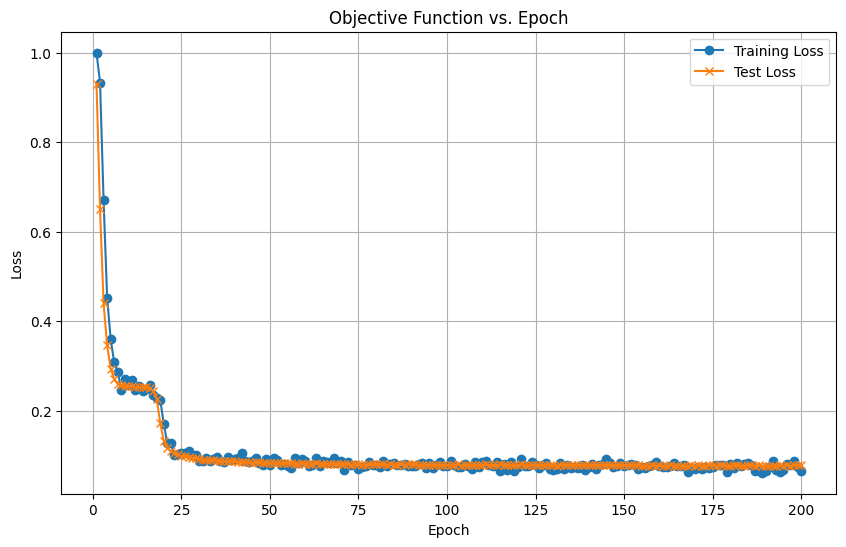

In [20]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
os.getcwd()

'/Users/jeqcho/astro-205/grb'

In [22]:
nr = True
dft = False

fname = "final_dft_Autoencoder_"
if nr:
    fname += "Noise_Reduced_"
fname += f"{swift.res}res_"
fname += f'{"".join(str(b) for b in swift.n_bands)}bands_'
if dft:
    fname += f'DFT_'
# notes
fname += f'final-3-latent'


torch.save(AE.state_dict(), f'{fname}state_dict.pth')
# torch.save(AE, f'{fname}.pth')
print(f"Model saved to  f'{fname}state_dict.pth")

Model saved to  f'final_dft_Autoencoder_Noise_Reduced_64res_12345bands_final-3-latentstate_dict.pth


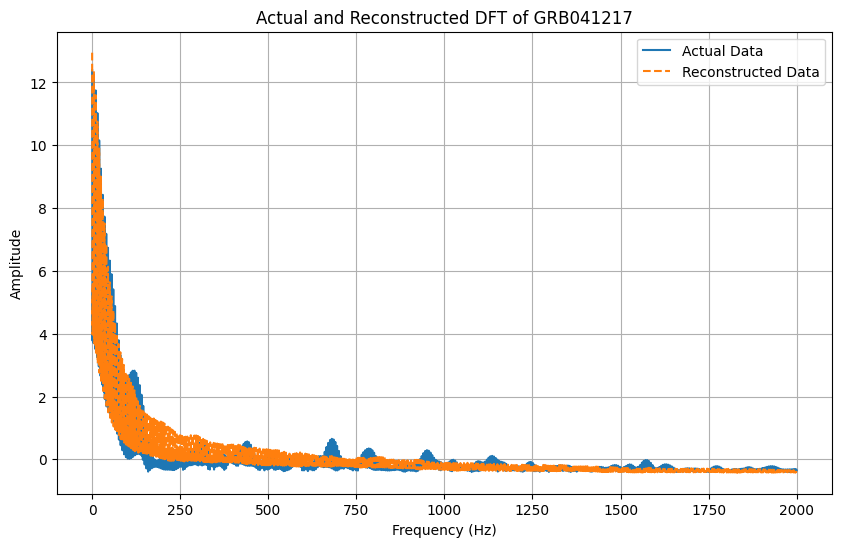

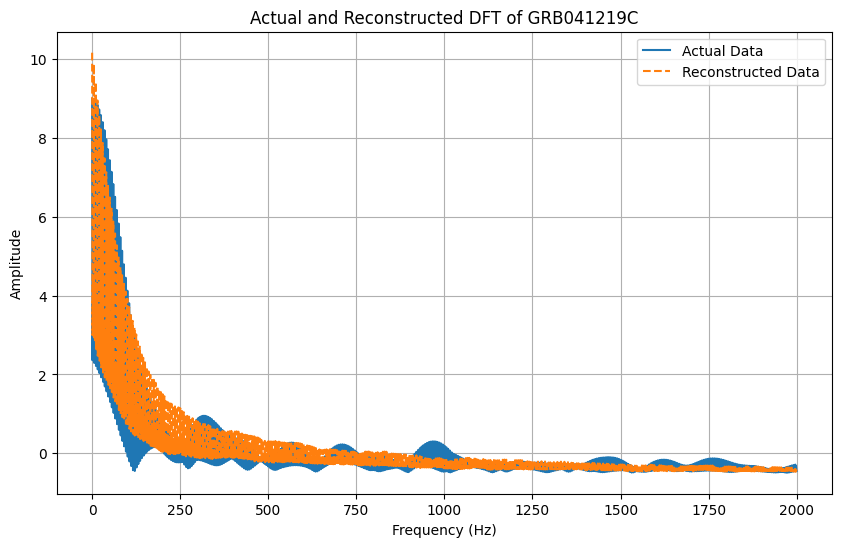

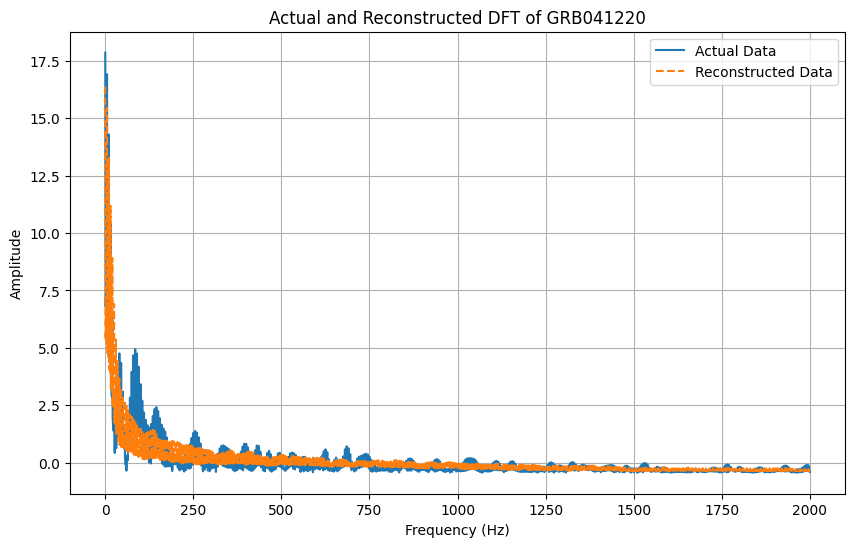

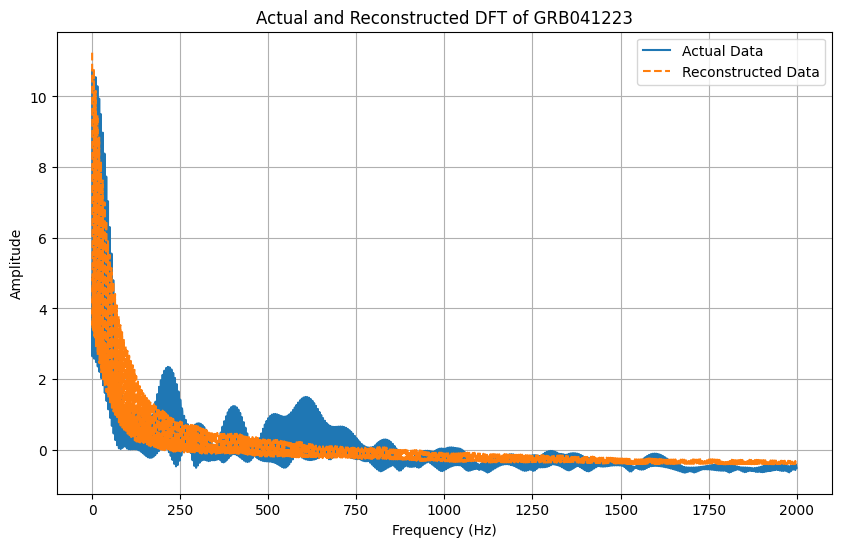

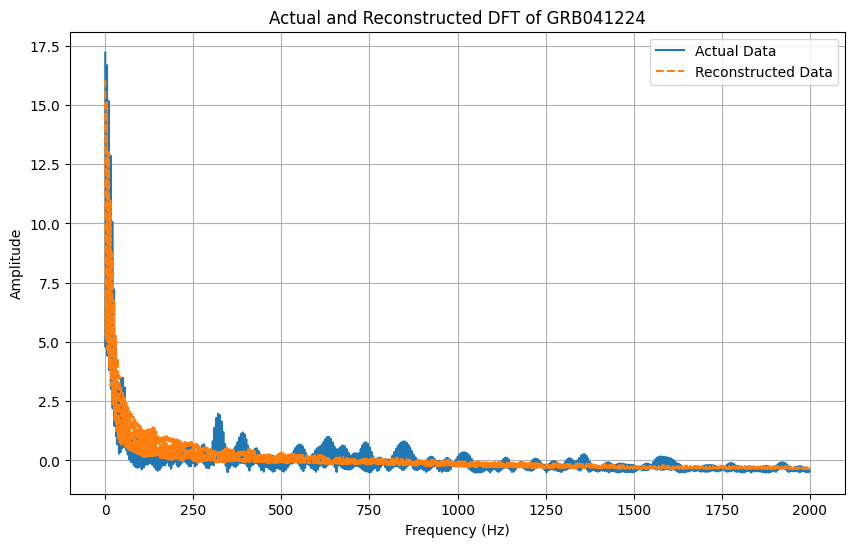

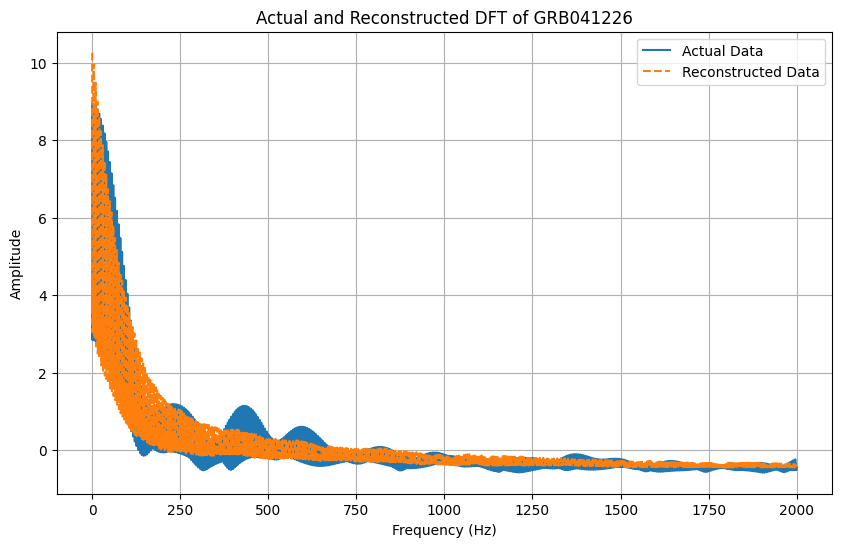

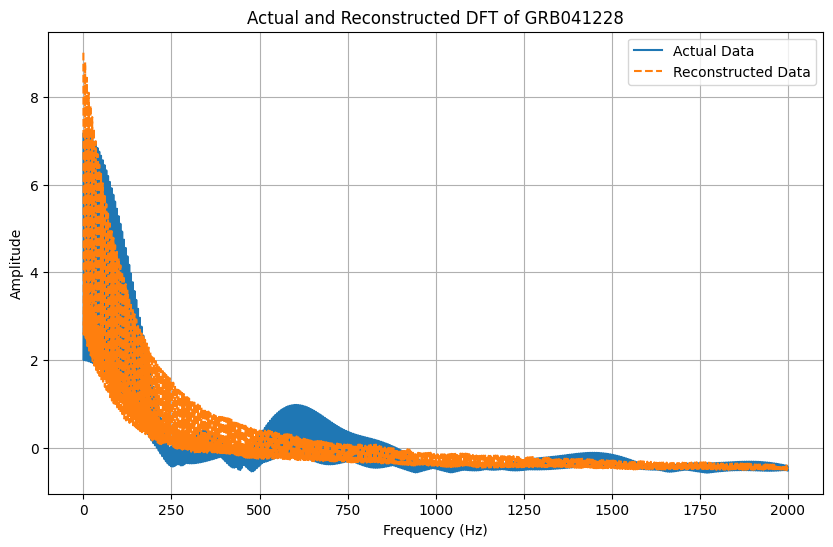

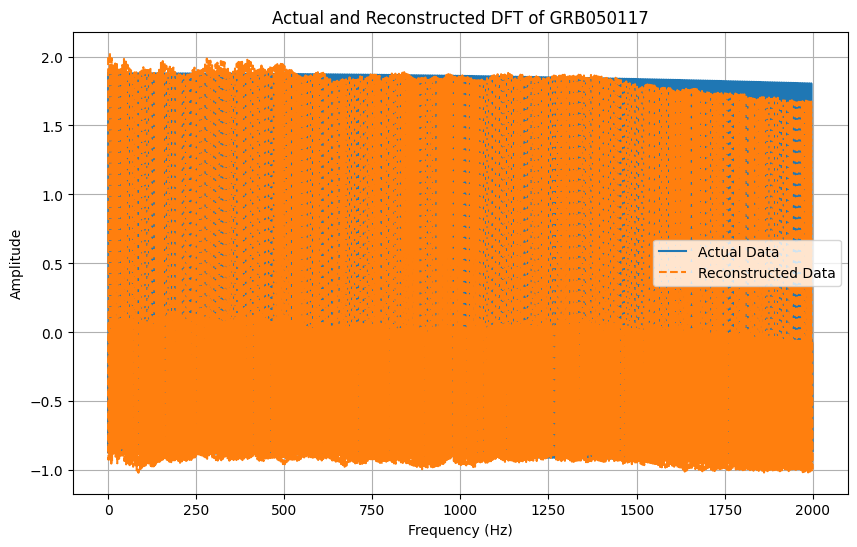

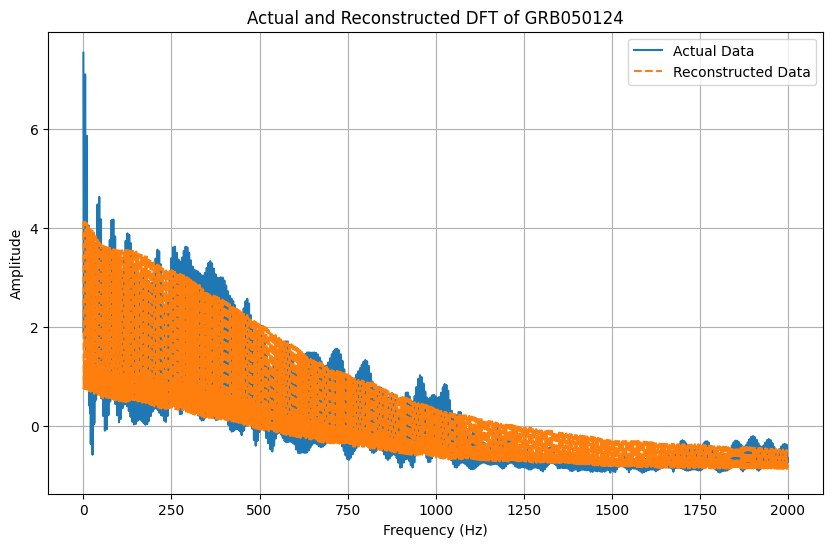

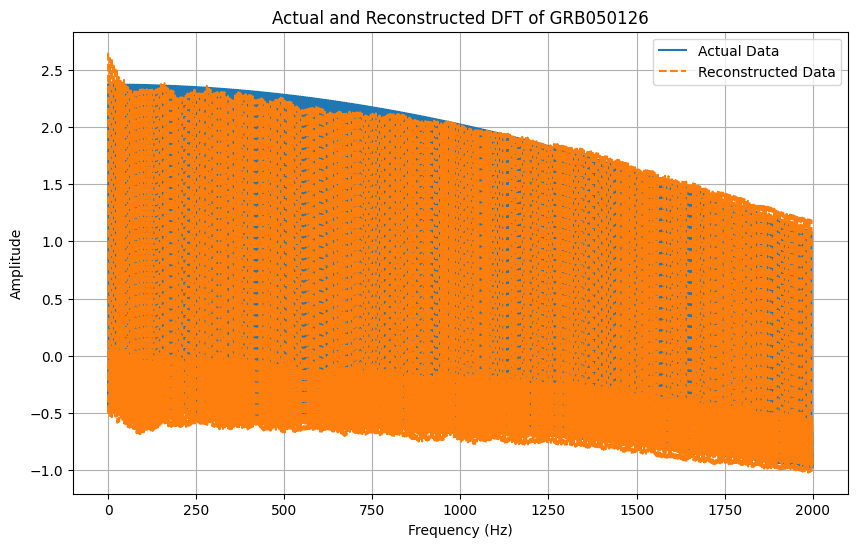

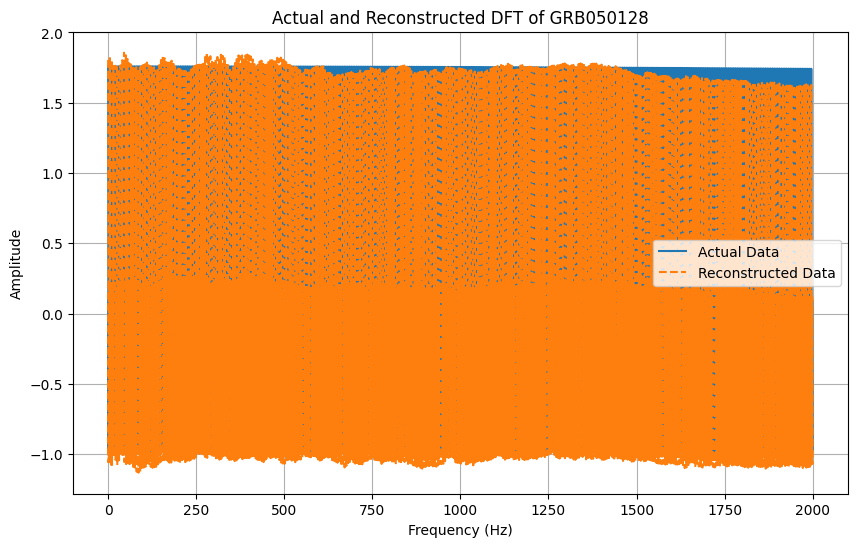

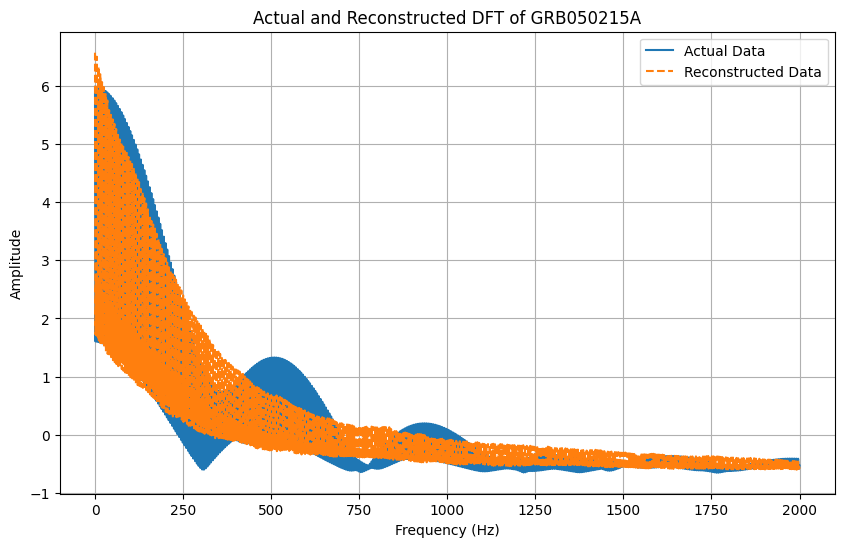

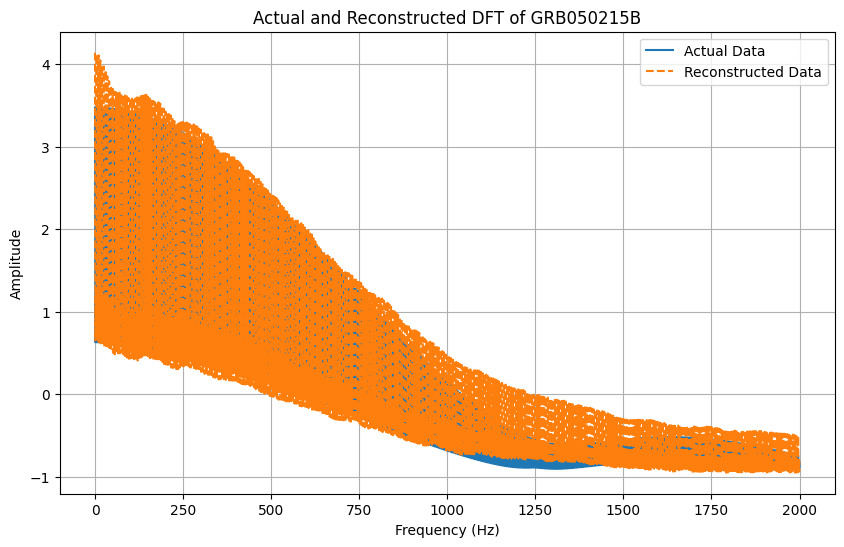

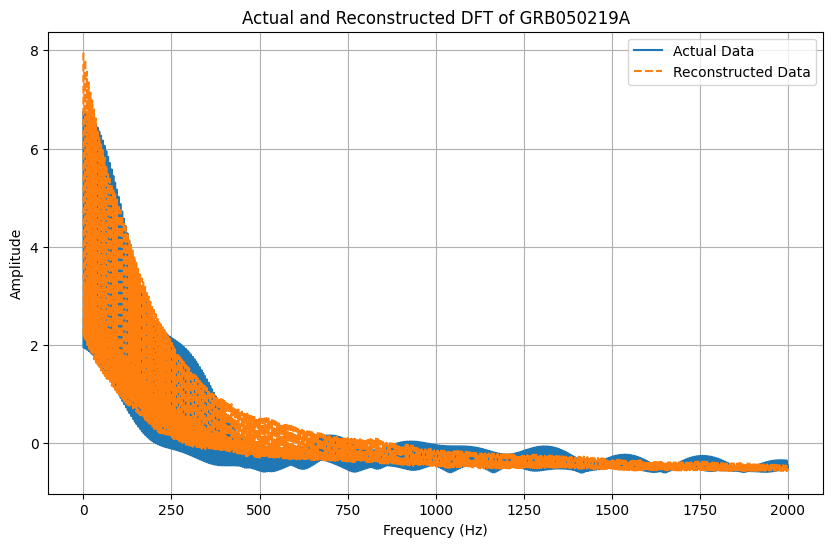

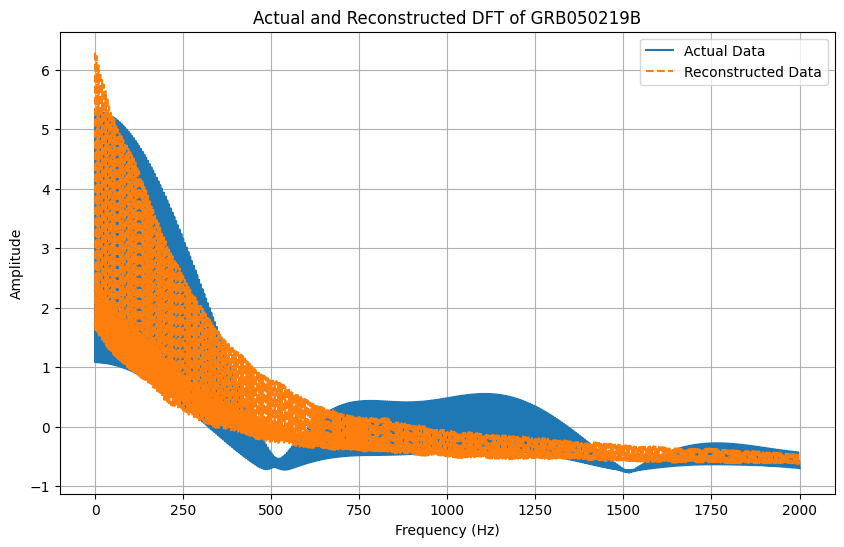

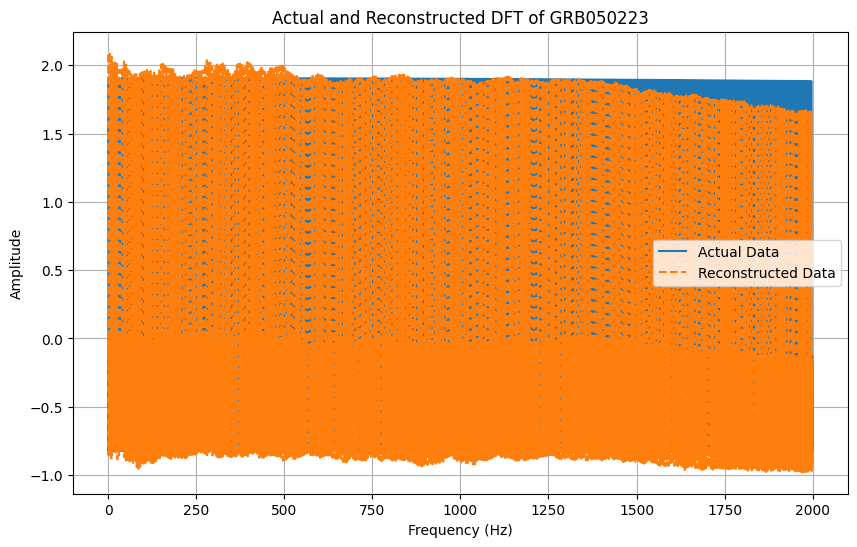

In [23]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Data')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Data',linestyle='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f'Actual and Reconstructed DFT of {grb_names[i]}')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

In [24]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[-32.2088,  57.6067],
        [-15.5939,  60.3959],
        [-39.2564,  56.0601],
        ...,
        [-21.5427,  57.9178],
        [ -1.5283,  53.5535],
        [ -2.1532,  58.0378]])

In [25]:
mask = ~torch.isnan(preds2).any(dim=1)
preds2 = preds2[mask]
torch.sum(~mask)

tensor(0)

In [26]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


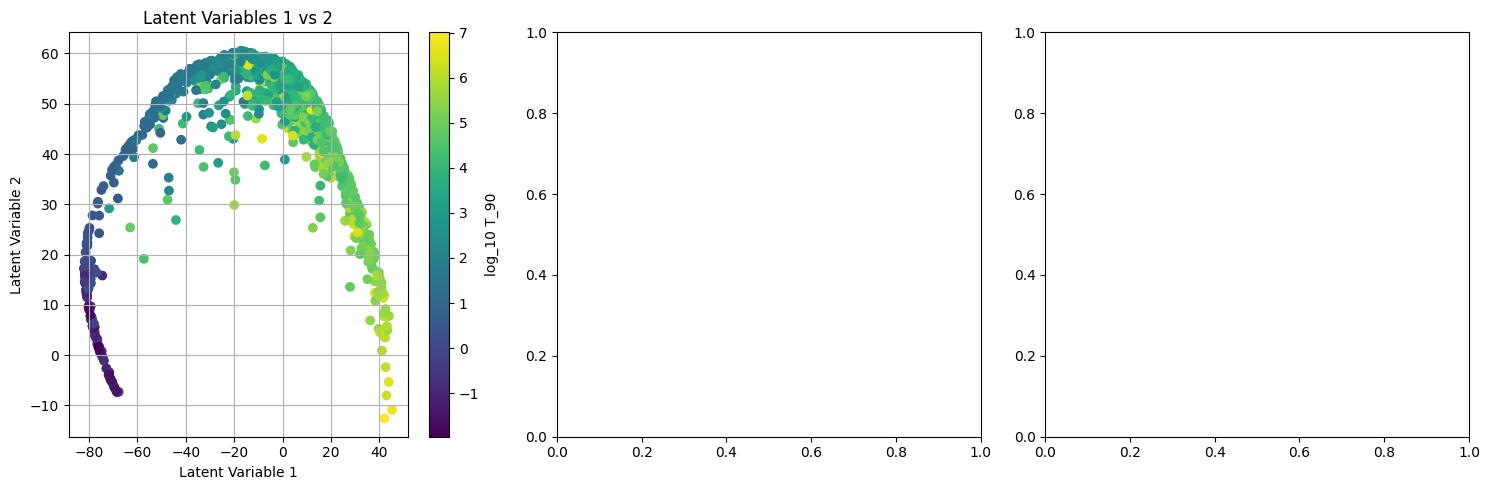

In [54]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
nrows = 1
ncols = 3
figsize = (15,5)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [28]:
compact_mergers = [
    "GRB130603B",
    "GRB060614",
    "GRB080503",
    "GRB050709",
    "GRB050724",
    "GRB061006",
    "GRB070714B",
    "GRB160821B",
    "GRB111005A",
    "GRB150101B",
    "GRB070809",
    "GRB211211A",
    "GRB211227A",
    "GRB191019A",
    "GRB230307A"
]
indices = np.where(np.isin(grb_names, compact_mergers))[0]
mask_not_in_indices = ~np.isin(range(len(preds2)), indices)
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

In [29]:
from sklearn.cluster import KMeans

encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

In [30]:
# Get all permutations of three columns out of five (0-based indices)

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], 
                                     c='r')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

IndexError: index 2 is out of bounds for dimension 1 with size 2

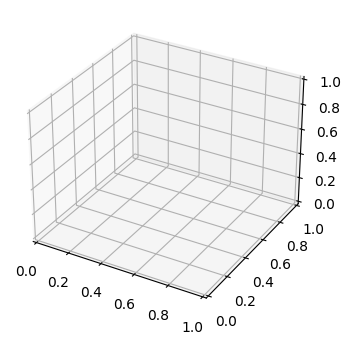

In [31]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()

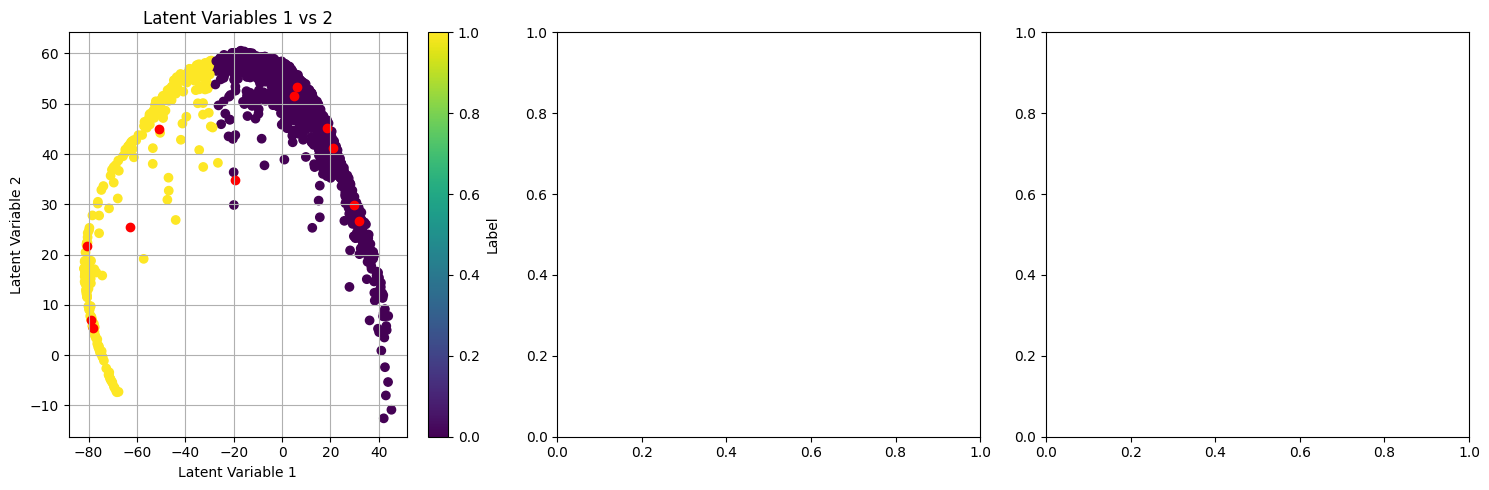

In [32]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), 
                         c=kmeans2.labels_[mask_not_in_indices], cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [33]:
encoded = preds2

In [34]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

In [35]:
names_64ms = names_64ms[mask]

In [36]:
# Values
values = np.array([0, 1])

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.993248 0.906157 0.143936 1.      ]


In [37]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

Finding Durations: 100%|██████████████████| 1219/1219 [00:06<00:00, 192.06GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=2')

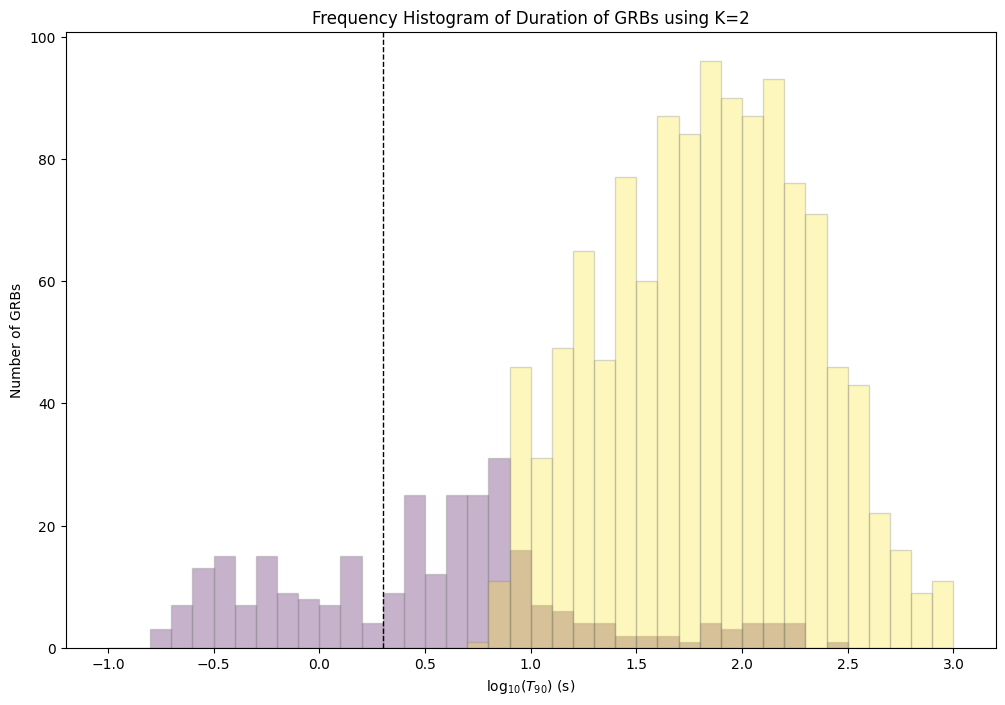

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=2')

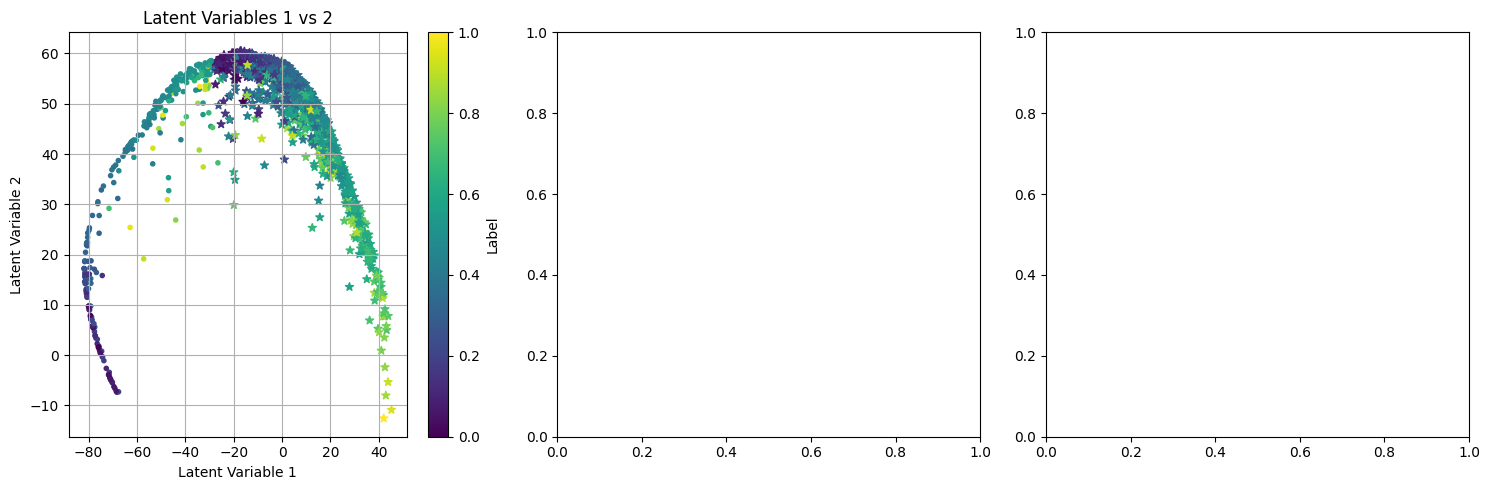

In [39]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

labls = kmeans2.labels_
centers = kmeans2.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2']

markers = ['*', '.']
edgecolors = ['red', 'black']

fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [40]:
import numpy as np


# Exploring the array
print("Shape of the array:", durations[mask].shape)
print("Data type of the array:", durations[mask].dtype)
print("Number of dimensions:", durations[mask].ndim)
print("Total number of elements:", durations[mask].size)

# Describing the durations[mask]
print("Mean of the array:", np.mean(durations[mask]))
print("Standard deviation:", np.std(durations[mask]))
print("Minimum value:", np.min(durations[mask]))
print("Maximum value:", np.max(durations[mask]))
print("25th percentile:", np.percentile(durations[mask], 25))
print("Median:", np.median(durations[mask]))
print("75th percentile:", np.percentile(durations[mask], 75))
print("90th percentile:", np.percentile(durations[mask], 90))
print("95th percentile:", np.percentile(durations[mask], 95))
print("99th percentile:", np.percentile(durations[mask], 99))

Shape of the array: (1513,)
Data type of the array: float64
Number of dimensions: 1
Total number of elements: 1513
Mean of the array: 76.21325842696629
Standard deviation: 107.63104972105164
Minimum value: 0.14
Maximum value: 1104.7520000000002
25th percentile: 11.904
Median: 41.0
75th percentile: 97.69999999999999
90th percentile: 181.992
95th percentile: 270.82320000000004
99th percentile: 545.7420799999968


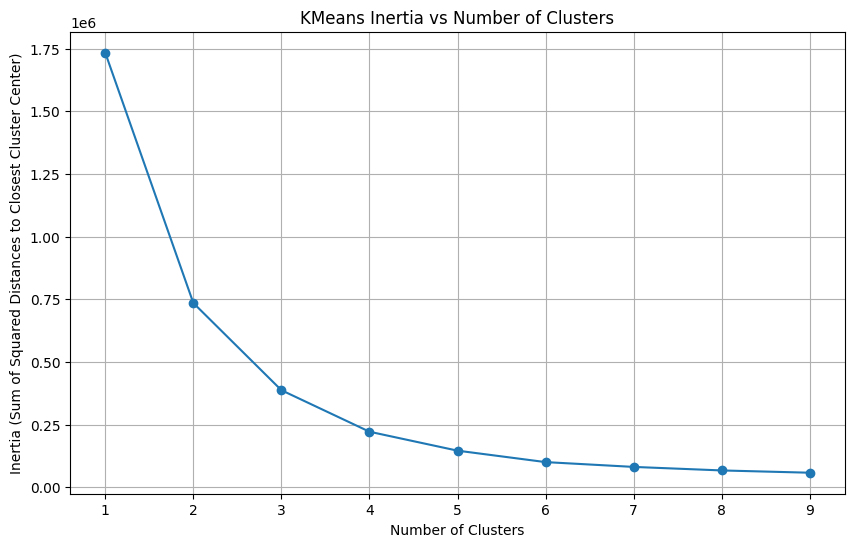

In [41]:
# Try different numbers of clusters
num_clusters = range(1, 10)  # You can adjust the range as needed
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=205)
    kmeans.fit(encoded2)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances to Closest Cluster Center)')
plt.grid(True)
plt.show()

In [42]:
kmeans3 = KMeans(n_clusters=3, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

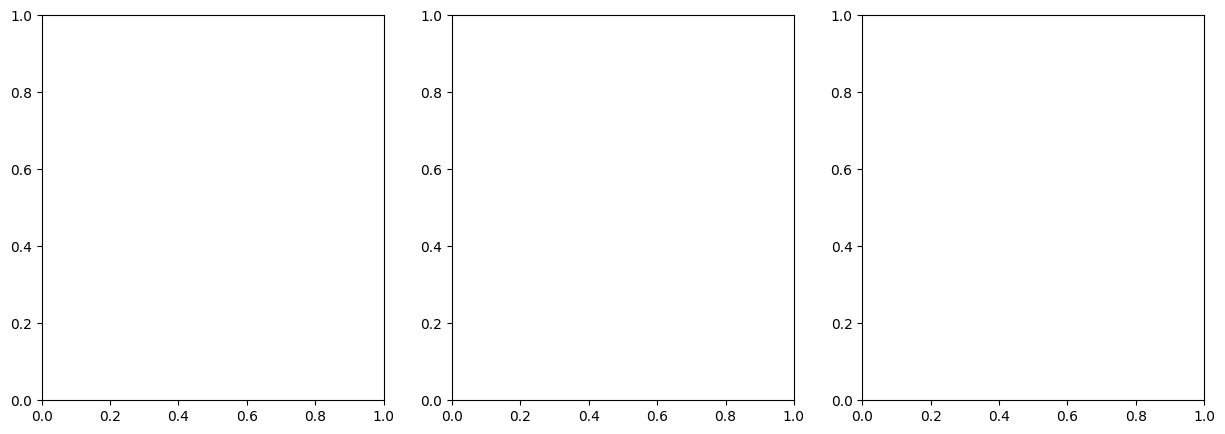

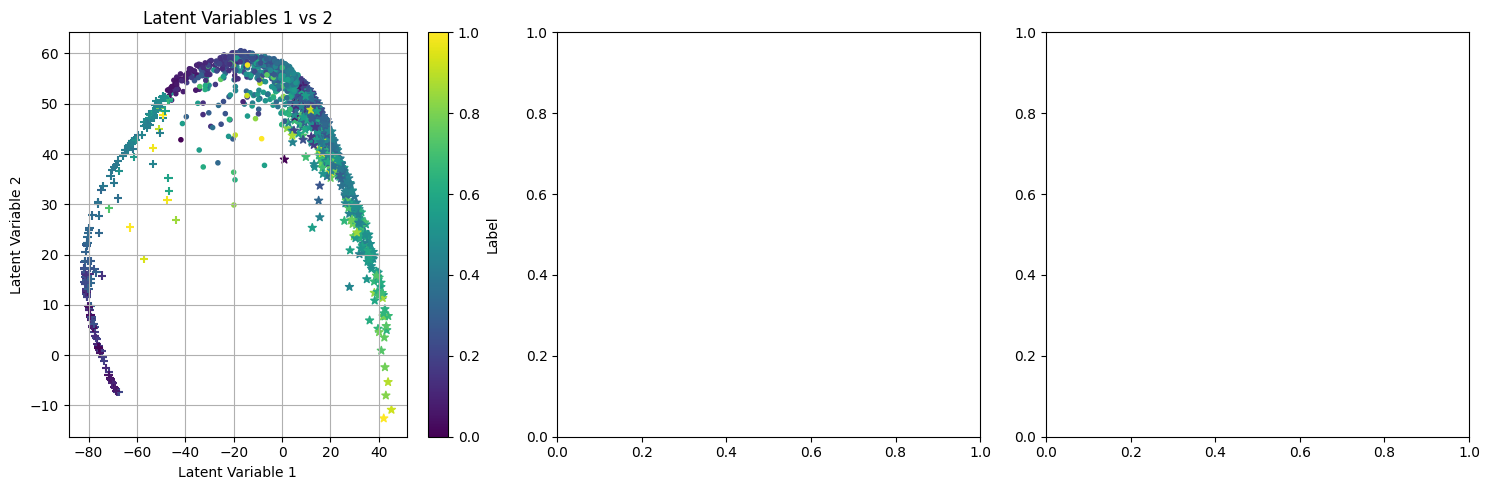

In [43]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

labls = kmeans3.labels_
centers = kmeans3.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2','g3']

markers = ['*', '.','+']
edgecolors = ['red', 'black']


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

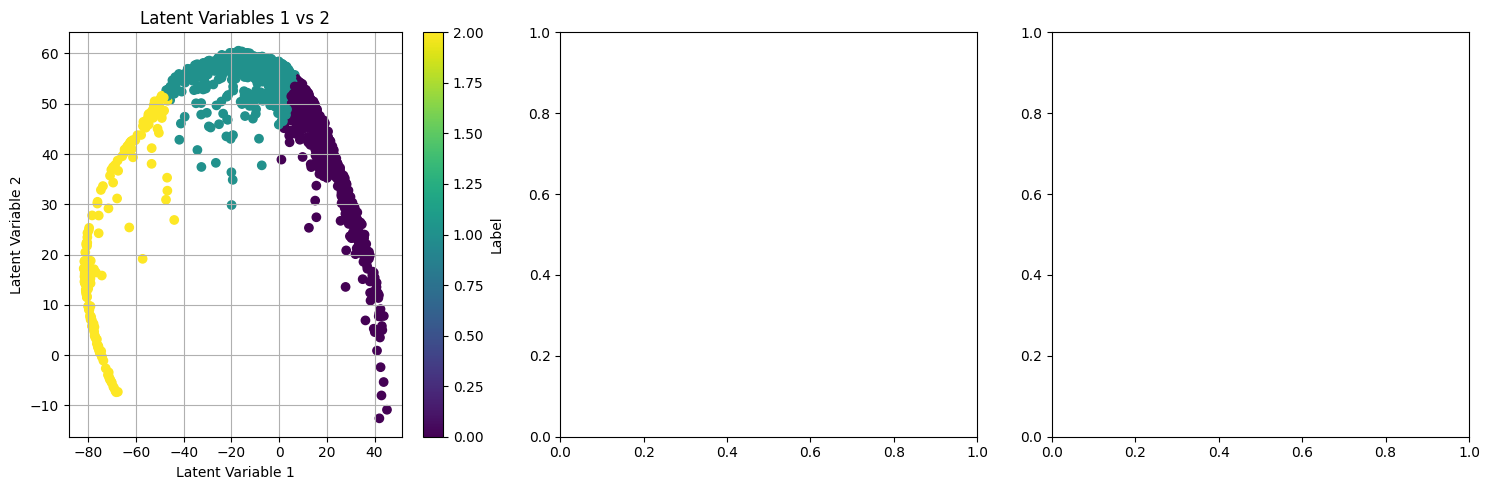

In [44]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans3.labels_, cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [45]:
# Values
values = np.arange(3)

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.127568 0.566949 0.550556 1.      ]
Value 2 has color: [0.993248 0.906157 0.143936 1.      ]


Finding Durations: 100%|█████████████████████| 187/187 [00:06<00:00, 26.84GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=3')

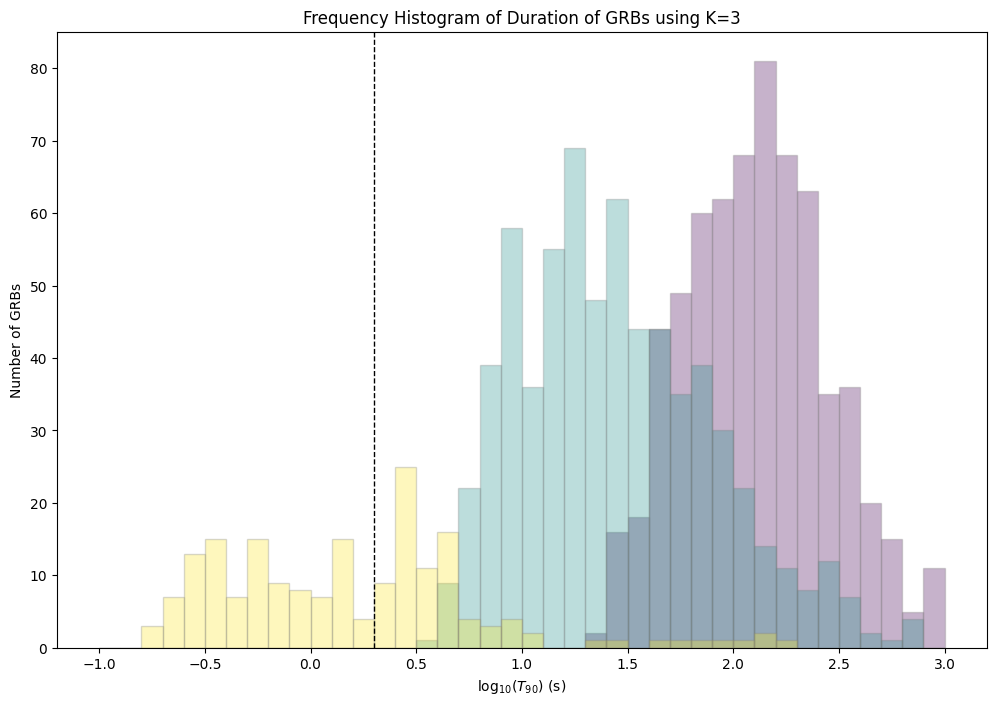

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans3.labels_==0
match2 = kmeans3.labels_==1
match3 = kmeans3.labels_==2
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
swift.duration_histogram(names=[names1, names2, names3], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=3')

In [47]:
torch.sum(~mask)

tensor(0)

In [48]:
# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    _indices = np.where(names_64ms == merger)[0]
    results[merger] = _indices[0] if _indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans2.labels_[value]}")

GRB130603B: 1
GRB060614: 0
GRB080503: 0
GRB050709: 0
GRB050724: 0
GRB061006: 1
GRB070714B: 1
GRB160821B: 1
GRB111005A: 0
GRB150101B: 0
GRB070809: 1
GRB211211A: 0
GRB211227A: 0
GRB191019A: 0
GRB230307A: 0


In [49]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


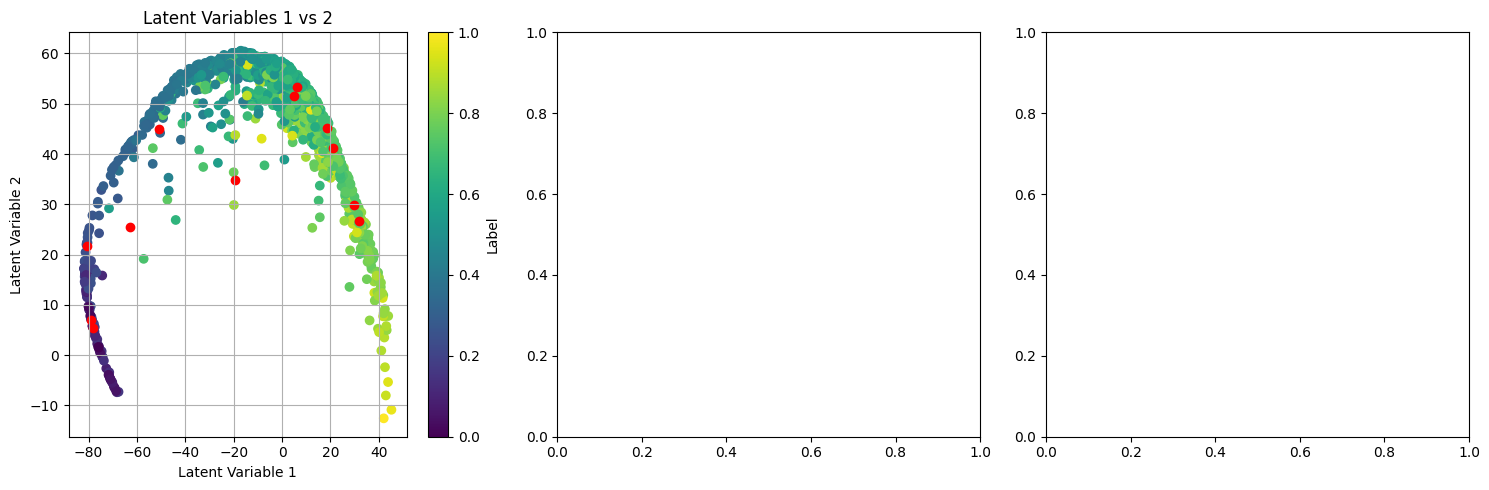

In [50]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), c=np.log(durations[mask_not_in_indices]), cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('log_10 T_90')

plt.tight_layout()
plt.show()

In [51]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


IndexError: index 2 is out of bounds for dimension 1 with size 2

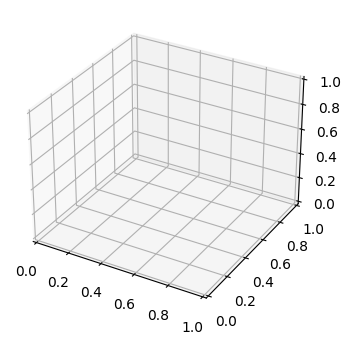

In [52]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()

In [ ]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [1,2,3]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')


In [ ]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [0,1,2]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')
